In [1]:
import pandas as pd
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import PC
from castle.common.priori_knowledge import PrioriKnowledge

import networkx as nx
from dowhy import gcm
import numpy as np
import matplotlib.pyplot as plt

2023-11-14 15:45:45,740 - /home/eisenbarth/dev/snt/sedan/postdoc/xrpl/flexi-pipe/data/.venv/lib/python3.11/site-packages/castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2023-11-14 15:45:45,833 - /home/eisenbarth/dev/snt/sedan/postdoc/xrpl/flexi-pipe/data/.venv/lib/python3.11/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [2]:
#Causal graph
causal_graph = nx.DiGraph([('d', 'messageReceived'),
                           ('d', 'graft'),
                           ('d', 'prune'),
                           ('d', 'iwant'),
                           ('dlo', 'graft'),
                           ('dhi', 'prune'),
                           ('dscore', 'graft'),
                           ('dscore', 'prune'),
                           ('dlazy', 'iwant'),
                           ('dlazy', 'ihave'),
                           ('dout', 'graft'),
                           ('dout', 'prune'),
                           ('gossipFactor', 'iwant'),
                           ('gossipFactor', 'ihave'),
                           ('interval', 'graft'),
                           ('interval', 'prune'),
                           ('interval', 'iwant'),
                           ('interval', 'ihave'),
                           ('topology', 'graft'),
                           ('topology', 'prune'),
                           ('topology', 'propagationTime'),
                           ('topology', 'messageReceived'),
                           ('prune', 'graft'),
                           ('prune', 'propagationTime'),
                           ('messageReceived', 'messageOverhead'),
                           ('messageOverhead', 'bandwidth'),
                           ('iwant', 'bandwidth'),
                           ('ihave', 'bandwidth'),
                           ('messageReceived', 'bandwidth')
                         ])

In [3]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)
print(causal_graph.nodes)

[[0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlaz

In [4]:
#Treat dataset

#Import data 
data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)

consolidated = consolidated.drop(columns=['identifier', 'n_nodes', 'consensus', 'messageDuplicated'])
consolidated = consolidated.rename(columns={'topology':'top'})
consolidated['topology'] = 0
consolidated.loc[consolidated['top'] == 'general', 'topology'] = 1
consolidated = consolidated.drop(columns=['top'])
# consolidated.head(100)

X = consolidated.to_numpy()
print(X)

[[8.000e+00 6.000e+00 1.200e+01 4.000e+00 8.000e+00 2.000e+00 2.500e-01
  1.000e+00 2.149e+03 1.262e+06 1.830e+03 1.682e+06 1.537e+03 1.250e+02
  1.700e+01 1.098e+05 0.000e+00]
 [8.000e+00 6.000e+00 1.200e+01 4.000e+00 8.000e+00 2.000e+00 2.500e-01
  3.000e+00 2.160e+03 1.220e+06 1.606e+03 1.844e+06 2.137e+03 0.000e+00
  1.000e+00 4.868e+03 0.000e+00]
 [1.600e+01 8.000e+00 2.000e+01 1.600e+01 8.000e+00 4.000e+00 5.000e-01
  1.000e+00 2.009e+03 9.919e+05 1.300e+03 1.428e+06 2.138e+03 0.000e+00
  0.000e+00 7.920e+02 0.000e+00]
 [1.600e+01 8.000e+00 2.000e+01 1.600e+01 8.000e+00 4.000e+00 5.000e-01
  5.000e-01 6.675e+03 3.889e+05 6.215e+02 7.629e+05 1.387e+03 1.350e+02
  1.200e+01 7.145e+04 0.000e+00]
 [6.000e+00 4.000e+00 8.000e+00 2.000e+00 2.000e+00 2.000e+00 2.500e-01
  1.000e+00 3.089e+03 8.594e+05 1.363e+03 1.778e+06 1.469e+03 3.080e+02
  4.600e+01 1.418e+05 0.000e+00]
 [6.000e+00 4.000e+00 8.000e+00 2.000e+00 2.000e+00 4.000e+00 2.500e-01
  5.000e-01 2.097e+03 3.912e+05 5.922e+02 8

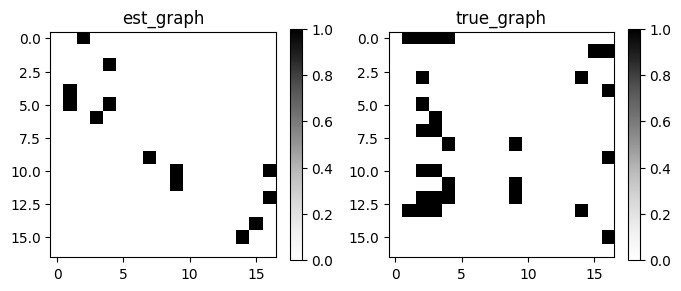

{'fdr': 0.75, 'tpr': 0.1034, 'fpr': 0.0841, 'shd': 35, 'nnz': 12, 'precision': 0.2308, 'recall': 0.1034, 'F1': 0.1429, 'gscore': 0.0}


/home/eisenbarth/dev/snt/sedan/postdoc/xrpl/flexi-pipe/data/.venv/lib/python3.11/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/eisenbarth/dev/snt/sedan/postdoc/xrpl/flexi-pipe/data/.venv/lib/python3.11/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/eisenbarth/dev/snt/sedan/postdoc/xrpl/flexi-pipe/data/.venv/lib/python3.11/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [5]:
# structure learning
priori = PrioriKnowledge(X.shape[1])
priori.add_forbidden_edges([(2,0),(0,6),(6,0),(3,6),(9,6),(9,10),(16,10),(16,12),(8,13),(13,8),(9,11),(7,11),(11,7),(10,7),(7,10)])
# (2,0) = graft -> d, (0,6) = d -> dhi, (6,0) = dhi -> d, (3,6) = prune -> dhi, (9,6) = ihave -> dhi, (9,10) = ihave -> dout
# (16,10) = bandwidth -> dout, (16,12) = bandwidth -> interval, (8,13) = dlazy -> topology, (13,8) = topology -> dlazy
# (9,11) = ihave -> gossipFactor, (7,11) = dScore -> gossipFactor, (11,7) = GossipFactor -> dScore, (10,7) = dout -> dScore, (7,10) = dScore -> dout
pc = PC(variant='original', priori_knowledge=priori)
pc.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc.causal_matrix, true_causal_matrix)
print(mt.metrics)

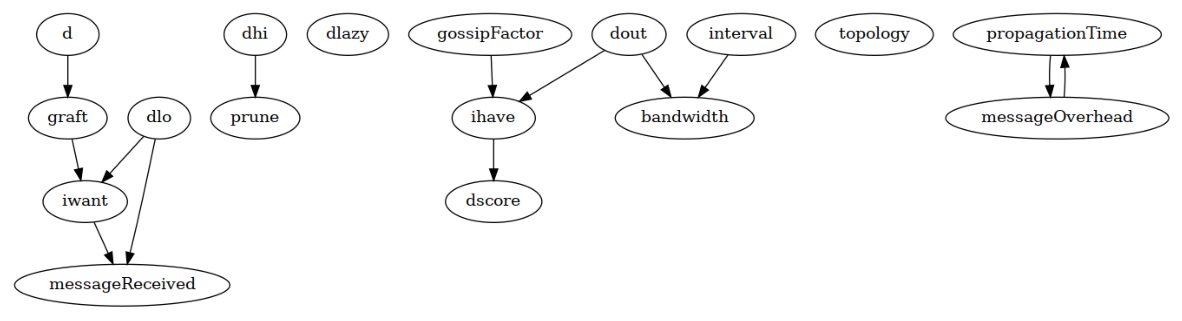

In [9]:
learned_causal_graph = nx.from_numpy_array(pc.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d', 1:'messageReceived', 2:'graft', 3:'prune', 4:'iwant', 5:'dlo', 6:'dhi', 7:'dscore', 8:'dlazy', 9:'ihave', 10:'dout', 11:'gossipFactor', 12:'interval', 13:'topology', 14:'propagationTime', 15:'messageOverhead', 16:'bandwidth'}
# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

fig, ax = plt.subplots(figsize=(15,20)) 
gcm.util.plot(H)#, figure_size=[15, 10])

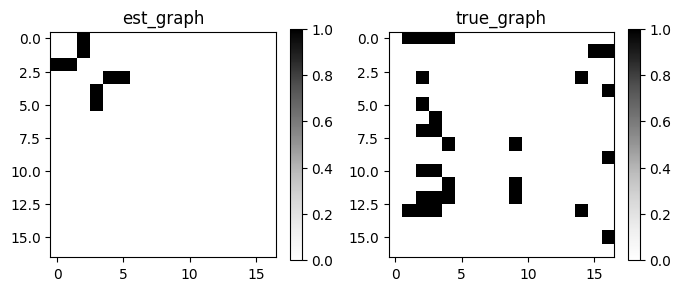

{'fdr': 0.75, 'tpr': 0.0345, 'fpr': 0.028, 'shd': 31, 'nnz': 4, 'precision': 0.125, 'recall': 0.0345, 'F1': 0.0541, 'gscore': 0.0}


In [42]:
pc_cat = PC(ci_test="chi2")

pc_cat.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc_cat.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc_cat.causal_matrix, true_causal_matrix)
print(mt.metrics)

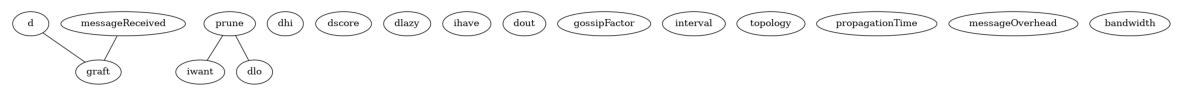

In [43]:
learned_causal_graph =  nx.from_numpy_array(pc_cat.causal_matrix)

mapping = {0:'d', 1:'messageReceived', 2:'graft', 3:'prune', 4:'iwant', 5:'dlo', 6:'dhi', 7:'dscore', 8:'dlazy', 9:'ihave', 10:'dout', 11:'gossipFactor', 12:'interval', 13:'topology', 14:'propagationTime', 15:'messageOverhead', 16:'bandwidth'}
# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

fig, ax = plt.subplots(figsize=(15,20)) 
gcm.util.plot(H)#, figure_size=[15, 10])

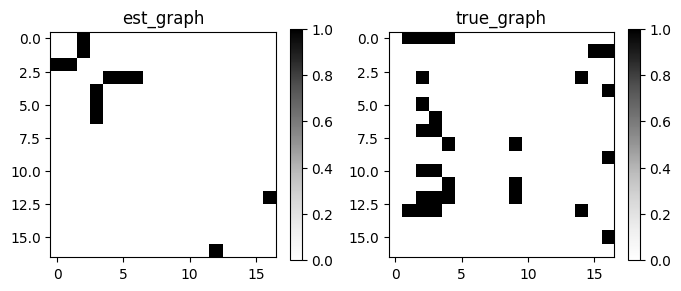

{'fdr': 0.6667, 'tpr': 0.069, 'fpr': 0.0374, 'shd': 31, 'nnz': 6, 'precision': 0.1667, 'recall': 0.069, 'F1': 0.0976, 'gscore': 0.0}


In [44]:
pc_g2 = PC(ci_test="g2")

pc_g2.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc_g2.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc_g2.causal_matrix, true_causal_matrix)
print(mt.metrics)

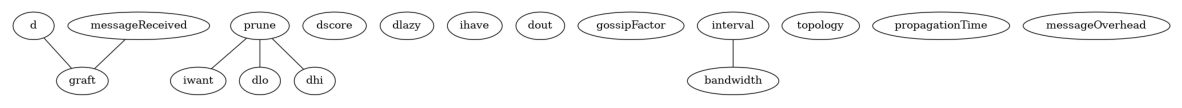

In [45]:
learned_causal_graph =  nx.from_numpy_array(pc_g2.causal_matrix)

mapping = {0:'d', 1:'messageReceived', 2:'graft', 3:'prune', 4:'iwant', 5:'dlo', 6:'dhi', 7:'dscore', 8:'dlazy', 9:'ihave', 10:'dout', 11:'gossipFactor', 12:'interval', 13:'topology', 14:'propagationTime', 15:'messageOverhead', 16:'bandwidth'}
# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

fig, ax = plt.subplots(figsize=(15,20)) 
gcm.util.plot(H)#, figure_size=[15, 10])

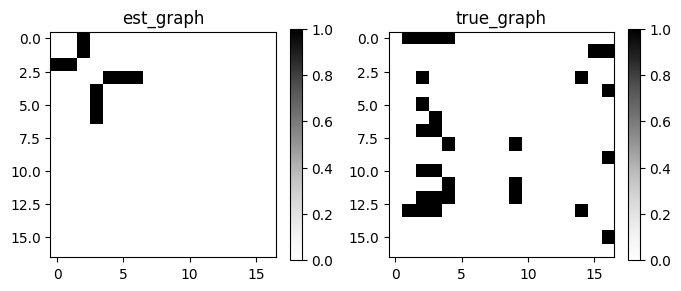

{'fdr': 0.6, 'tpr': 0.069, 'fpr': 0.028, 'shd': 30, 'nnz': 5, 'precision': 0.2, 'recall': 0.069, 'F1': 0.1026, 'gscore': 0.0}


In [46]:
from castle.common.independence_tests import CITest

pc_cat_alt = PC(ci_test=CITest.cressie_read)
pc_cat_alt.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc_cat_alt.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc_cat_alt.causal_matrix, true_causal_matrix)
print(mt.metrics)

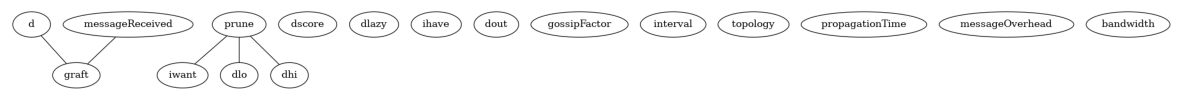

In [47]:
learned_causal_graph =  nx.from_numpy_array(pc_cat_alt.causal_matrix)

mapping = {0:'d', 1:'messageReceived', 2:'graft', 3:'prune', 4:'iwant', 5:'dlo', 6:'dhi', 7:'dscore', 8:'dlazy', 9:'ihave', 10:'dout', 11:'gossipFactor', 12:'interval', 13:'topology', 14:'propagationTime', 15:'messageOverhead', 16:'bandwidth'}
# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

fig, ax = plt.subplots(figsize=(15,20)) 
gcm.util.plot(H)#, figure_size=[15, 10])